<http://www.atmarkit.co.jp/ait/articles/1308/22/news002.html>
# ITエンジニアのためのデータサイエンティスト養成講座（5）
「ビールと紙おむつ」のような相関関係を探る分析手法にはどんなものがある？――データ分析方法についての検討 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')

ここでは前提として、「1日の電力使用量の最大値は最高気温と相関関係がある」という仮定に基づいて分析を進めていきます。

→「夏の暑い日は電気がたくさん使われる」

In [42]:
# 東京電力の電力使用状況のデータ（2013年)
# CSVデータ取得
df_power = pd.read_csv('http://www.tepco.co.jp/forecast/html/images/juyo-2013.csv',
                       skiprows=3, names=['date', 'time', 'actual'], encoding='Shift_JIS')
df_power.head()

,date,time,actual
0,2013/1/1,0:00,2873
1,2013/1/1,1:00,2716
2,2013/1/1,2:00,2592
3,2013/1/1,3:00,2482
4,2013/1/1,4:00,2412


In [43]:
# 時系列インデックスの作成
idx_power = pd.to_datetime(df_power['date'] + ' ' + df_power['time'])
df_power.index = idx_power #データフレームのindexに設定
df_power.head()

,date,time,actual
2013-01-01 00:00:00,2013/1/1,0:00,2873
2013-01-01 01:00:00,2013/1/1,1:00,2716
2013-01-01 02:00:00,2013/1/1,2:00,2592
2013-01-01 03:00:00,2013/1/1,3:00,2482
2013-01-01 04:00:00,2013/1/1,4:00,2412


In [44]:
# 不要列の削除
del df_power['date']
del df_power['time']
df_power.head()

,actual
2013-01-01 00:00:00,2873
2013-01-01 01:00:00,2716
2013-01-01 02:00:00,2592
2013-01-01 03:00:00,2482
2013-01-01 04:00:00,2412


In [45]:
#日次ダウンサンプリング（日次最大値)
df_power_daily = df_power.resample('D', how='max', kind='period')
df_power_daily.head()

,actual
2013-01-01,3132
2013-01-02,3106
2013-01-03,3558
2013-01-04,4016
2013-01-05,4089


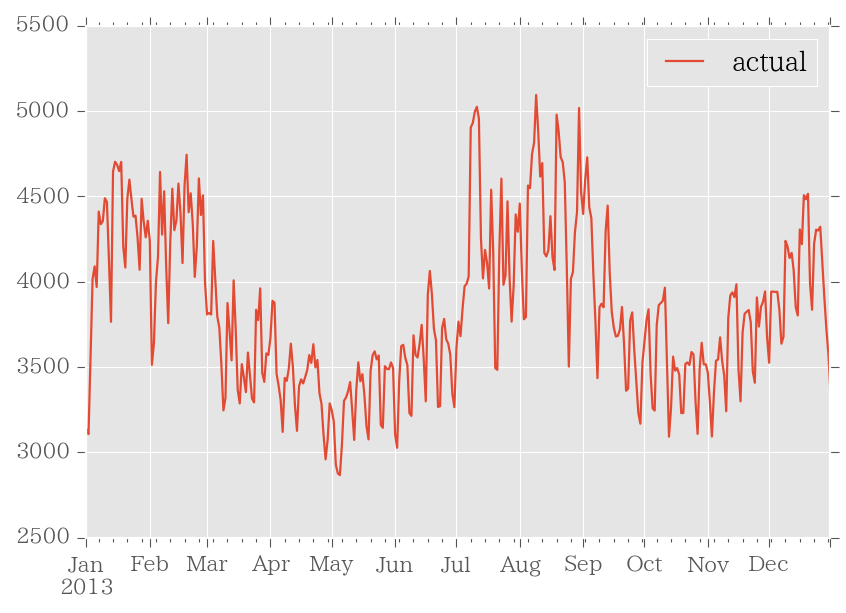

In [46]:
#プロットしてみる(2013年の東京都の電力使用量)
df_power_daily.plot()

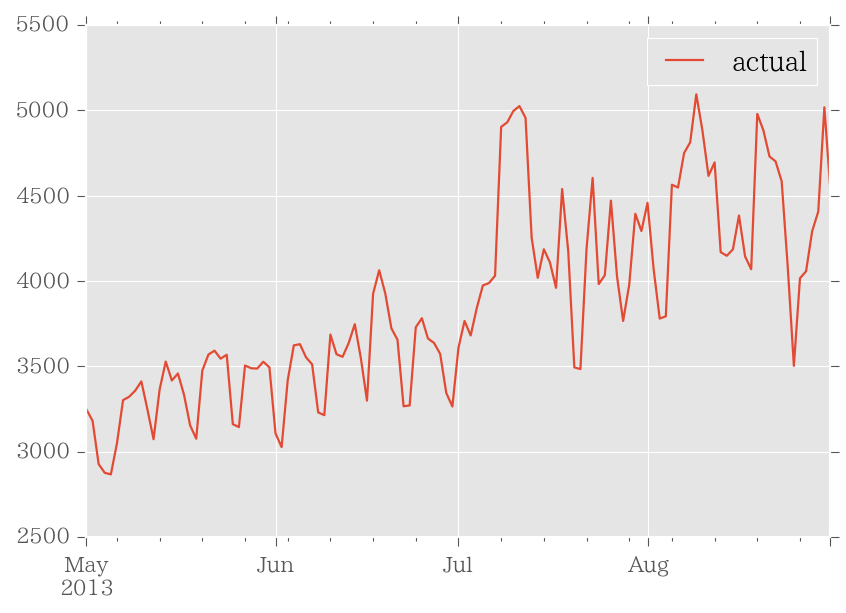

In [47]:
# 5月〜8月のデータに絞り込んで検証する
df_power_daily = df_power_daily.ix['2013-05-01': '2013-8-31']
df_power_daily.plot()

In [48]:
# 気象庁提供の東京都の最高気温、最低気温のデータを取り込み
# http://www.data.jma.go.jp/gmd/risk/obsdl/index.php 
# UIのあるページなのであらかじめダウンロードしたものを使用
df_temp = pd.read_csv('data/tokyo-temp-2013.csv', skiprows=6,
                      names=['date', 'high', None, None,'low', None, None], 
                      usecols=['date', 'high', 'low'],
                      parse_dates=['date'],
                      index_col=['date'],
                      encoding='Shift_JIS')
df_temp.head()

,high,low
date,,
2013-01-01,9.6,3.0
2013-01-02,14.4,4.2
2013-01-03,9.9,1.8
2013-01-04,6.9,1.0
2013-01-05,4.8,0.2


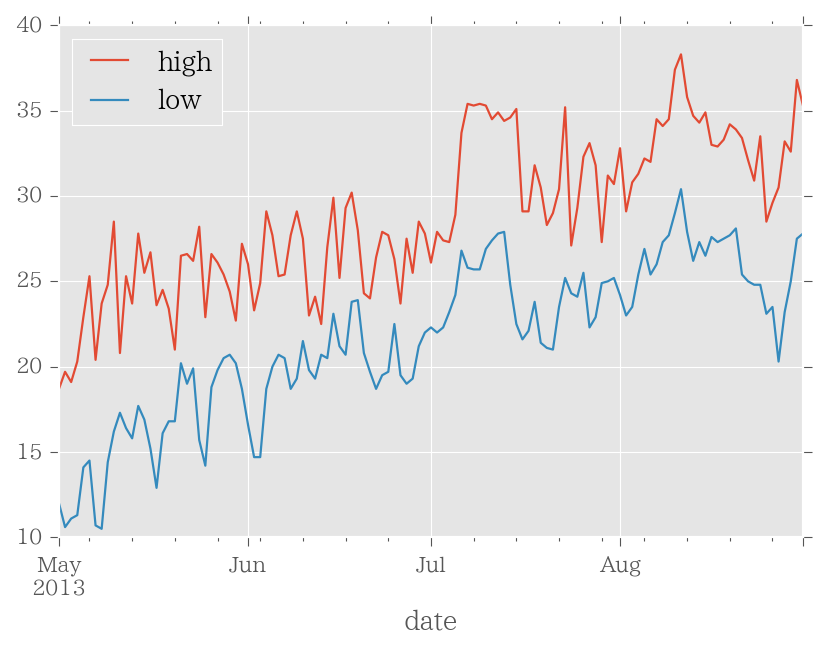

In [49]:
# 電力使用量と同じように5月〜8月のデータに絞り込んで検証する
df_temp = df_temp.ix['2013-05-01': '2013-8-31']
# 最高気温、最低気温のプロット
# →電力使用量と似た感じなのが分かる
df_temp.plot()

まずは、電力使用量を目的変数、最高気温を説明変数とした単回帰分析を用いて相関関係の有無を明らかにしていきます。

　電力使用量の方は冷房機器の影響と暖房機器の影響があり、また平日と週末の差が大きいので、冬期と夏期、平日と週末にそれぞれモデルを分けて検討する必要があると思われます。紙幅の都合から、今回は夏期・平日のモデルを検討します。

In [50]:
# 平日と休日では電力使用量に差があるので平日のみとする
#5月〜8月の平日のデータに絞り込む "B"は平日 http://goo.gl/3N4hM0

dfx = df_temp.resample('B', how='max', kind='period')
dfx.head(10)

,high,low
date,,
2013-05-01,18.7,12.0
2013-05-02,19.7,10.6
2013-05-03,22.9,14.1
2013-05-06,25.3,14.5
2013-05-07,20.4,10.7
2013-05-08,23.7,10.5
2013-05-09,24.8,14.4
2013-05-10,28.5,17.3
2013-05-13,23.7,15.8


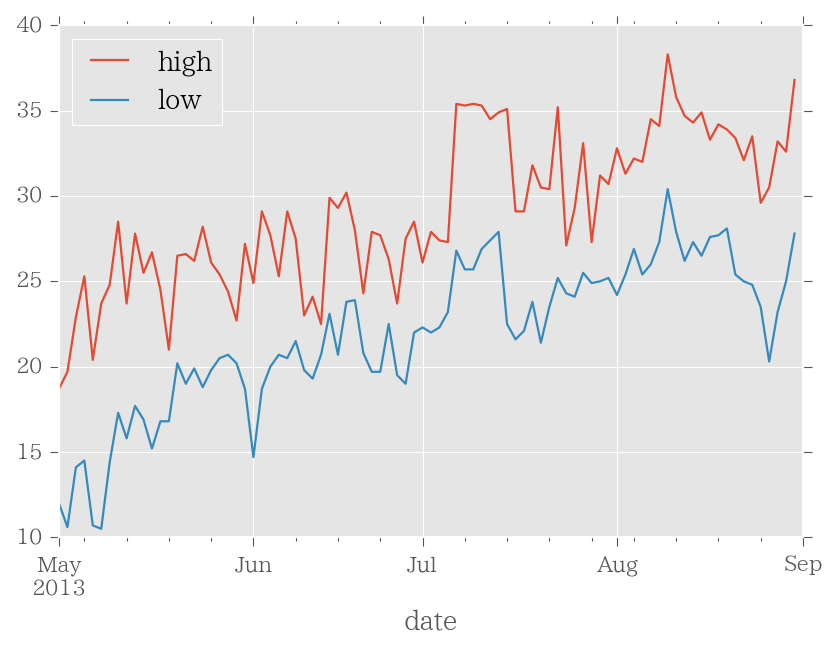

In [51]:
# グラフ表示
dfx.plot()


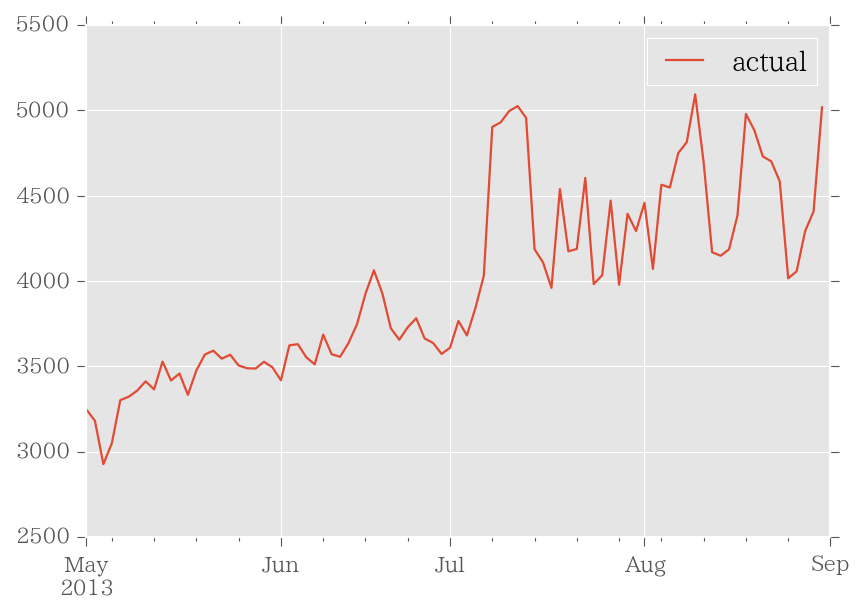

In [52]:
#日次電力使用最大値も平日のデータに絞り込む
dfy = df_power_daily.resample('B', how='max', kind='period')
dfy.plot()

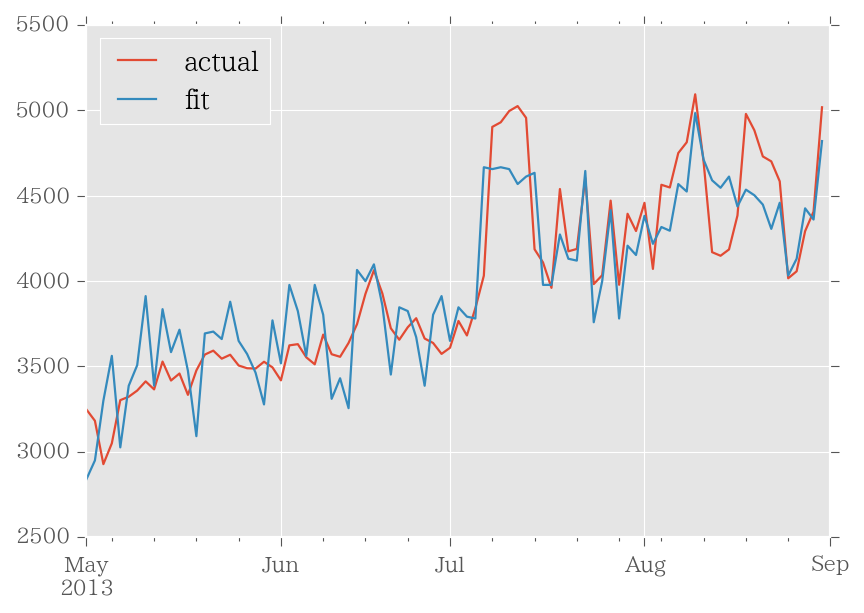

In [54]:
# 単回帰分析によるモデルを作成
# 電力使用実測値yを、最高気温xから予測できるか？

# 具体的な中身については次回以降。
model = pd.ols(y=dfy['actual'], x=dfx['high'], intercept=True)
dfy['fit'] = model.y_fitted
dfy.plot()

In [55]:
model


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   2

R-squared:         0.7831
Adj R-squared:     0.7805

Rmse:            256.0183

F-stat (1, 86):   310.4312, p-value:     0.0000

Degrees of Freedom: model 1, resid 86

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x   109.4269     6.2107      17.62     0.0000    97.2539   121.5999
     intercept   791.9707   182.7528       4.33     0.0000   433.7753  1150.1661
---------------------------------End of Summary---------------------------------